In [35]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
import time
import random
import glob

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.io import read_image
from torchvision.models import vgg16
from torchvision.transforms import v2
from torch.utils.data import DataLoader

# seed
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [36]:
# model
model = vgg16(pretrained=True)
model = nn.DataParallel(model)
model.to(device)

# data
img_paths = glob.glob("./data/Zeiler-Fergus/*")
labels = [366, 355, 312, 261, 298]

In [37]:
'''課題3.3 発展
SmoothGradによるCNNの可視化
'''

img_idx = 3
o_img = read_image(img_paths[img_idx])
label = labels[img_idx]

In [38]:
def smooth_grad(model, input_tensor, label, stdev_spread=0.15, nsamples=50):
    model.zero_grad()
    input_tensor.requires_grad_()

    # 入力のレンジ
    data_range = input_tensor.max() - input_tensor.min()
    stdev = stdev_spread * data_range.item()

    total_grad = torch.zeros_like(input_tensor)
    for i in range(nsamples):
        # ノイズ付き入力
        noise = torch.randn_like(input_tensor) * stdev
        noisy_input = (input_tensor + noise).clone().detach()
        noisy_input.requires_grad_()

        output = model(noisy_input)
        score = output[0, label]
        score.backward()

        # 勾配を蓄積
        total_grad += noisy_input.grad.abs()
        model.zero_grad()

    avg_grad = total_grad / nsamples
    saliency = avg_grad.squeeze().permute(1,2,0).cpu().numpy()
    # 正規化
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())
    
    return saliency

In [39]:
# exp
transform_1 = v2.Compose([
    v2.Resize([256, 256]),
    v2.ToDtype(torch.float, scale=True),
])
transform_2 = v2.Compose([
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_1 = transform_1(o_img)
img_2 = transform_2(img_1).unsqueeze(0)
img_2.to(device)

for param in model.parameters():
    param.requires_grad = False

saliency = smooth_grad(model, img_2, label)

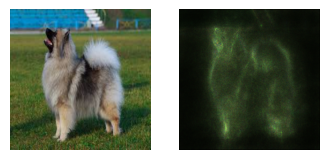

In [40]:
plt.figure(figsize=(4,4))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img_1.permute(1,2,0))

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(saliency, cmap='jet', vmin=0, vmax=1)